<a href="https://colab.research.google.com/github/newmantic/multigrid/blob/main/multigrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np

def relax(u, f, omega=1.0, iterations=1):
    n = u.shape[0]
    if n <= 1:
        raise ValueError("Grid size too small for relaxation.")
    h2 = (1.0 / (n - 1)) ** 2

    for _ in range(iterations):
        for i in range(1, n-1):
            for j in range(1, n-1):
                u[i, j] = (1 - omega) * u[i, j] + omega * 0.25 * (
                    u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - h2 * f[i, j]
                )
    return u

def restrict(u):
    n = u.shape[0]
    if n <= 3:  # Adjusted condition to prevent over-restriction
        raise ValueError("Grid size too small to restrict further.")
    nc = (n - 1) // 2 + 1
    uc = np.zeros((nc, nc))

    for i in range(1, nc-1):
        for j in range(1, nc-1):
            uc[i, j] = 0.25 * (u[2*i, 2*j] + 0.5 * (u[2*i-1, 2*j] + u[2*i+1, 2*j] + u[2*i, 2*j-1] + u[2*i, 2*j+1]) + 0.25 * (u[2*i-1, 2*j-1] + u[2*i-1, 2*j+1] + u[2*i+1, 2*j-1] + u[2*i+1, 2*j+1]))

    return uc

def prolong(uc):
    nc = uc.shape[0]
    n = 2 * (nc - 1) + 1
    u = np.zeros((n, n))

    for i in range(nc-1):
        for j in range(nc-1):
            u[2*i, 2*j] = uc[i, j]
            u[2*i+1, 2*j] = 0.5 * (uc[i, j] + uc[i+1, j])
            u[2*i, 2*j+1] = 0.5 * (uc[i, j] + uc[i, j+1])
            u[2*i+1, 2*j+1] = 0.25 * (uc[i, j] + uc[i+1, j] + uc[i, j+1] + uc[i+1, j+1])

    return u

def calculate_residual(u, f):
    n = u.shape[0]
    residual = np.zeros_like(u)

    for i in range(1, n-1):
        for j in range(1, n-1):
            residual[i, j] = f[i, j] - (-4*u[i, j] + u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])

    return residual

def v_cycle(u, f, level, max_level):
    n = u.shape[0]

    if level == max_level or n <= 3:
        u = relax(u, f, iterations=10)
    else:
        u = relax(u, f, iterations=3)
        residual = calculate_residual(u, f)
        residual_coarse = restrict(residual)
        u_coarse = np.zeros_like(residual_coarse)
        u_coarse = v_cycle(u_coarse, residual_coarse, level+1, max_level)
        u_fine = prolong(u_coarse)

        # Adjust the size to match the fine grid
        u += u_fine[:u.shape[0], :u.shape[1]]
        u = relax(u, f, iterations=3)

    return u

def multigrid(f, grid_size, max_level):
    u = np.zeros((grid_size, grid_size))
    u = v_cycle(u, f, 1, max_level)
    return u

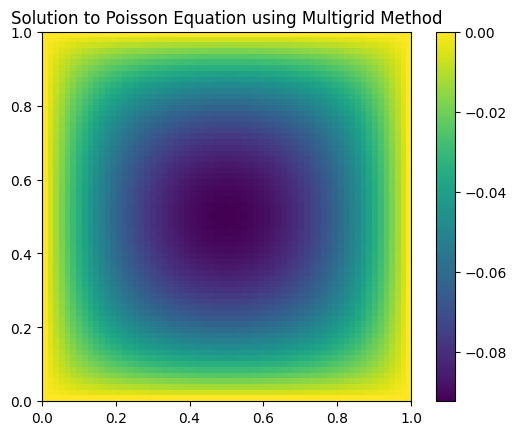

In [14]:
def test_case_1():
    grid_size = 65  # Fine grid
    max_level = int(np.log2(grid_size - 1))
    f = np.ones((grid_size, grid_size))

    u = multigrid(f, grid_size, max_level)

    # Plot the result
    import matplotlib.pyplot as plt
    plt.imshow(u, extent=[0, 1, 0, 1], origin='lower')
    plt.colorbar()
    plt.title('Solution to Poisson Equation using Multigrid Method')
    plt.show()

test_case_1()

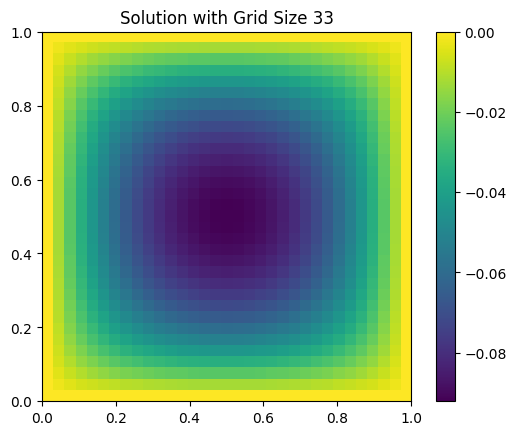

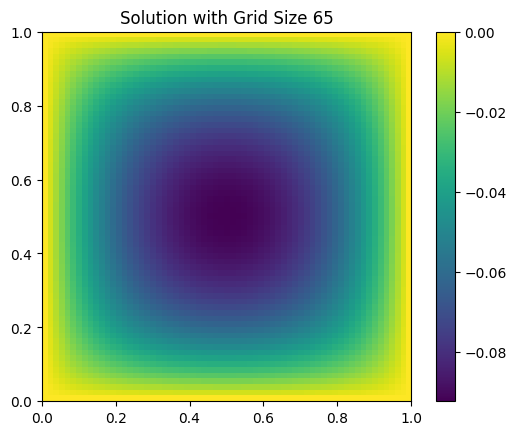

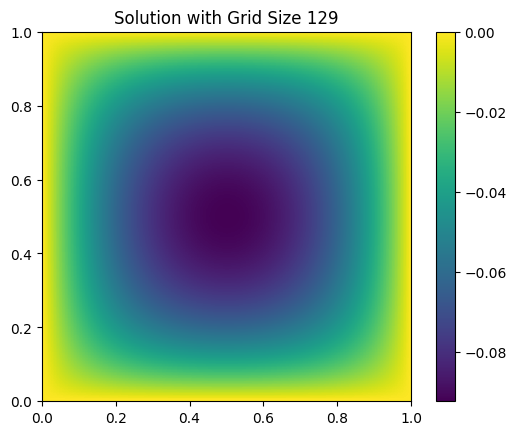

In [13]:
def test_case_2():
    grid_sizes = [33, 65, 129]  # Different grid sizes
    max_level = int(np.log2(grid_sizes[-1] - 1))
    f = np.ones((grid_sizes[-1], grid_sizes[-1]))

    for grid_size in grid_sizes:
        u = multigrid(f[:grid_size, :grid_size], grid_size, max_level)

        # Plot the result for each grid size
        import matplotlib.pyplot as plt
        plt.figure()
        plt.imshow(u, extent=[0, 1, 0, 1], origin='lower')
        plt.colorbar()
        plt.title(f'Solution with Grid Size {grid_size}')
        plt.show()

test_case_2()